In [4]:
import numpy as np
import matplotlib.pyplot as plt
def myfft2(A): 
    return np.fft.fftshift(np.fft.fft2(np.fft.fftshift(A)))
def myifft2(A): 
    return np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(A)))
#from skimage.metrics import structural_similarity as ssim
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow import keras
def base_model():
    model = Sequential()
    model.add(Dense(dim**2, input_dim= 2*dim ** 2, activation='linear', use_bias=False))  
    model.compile(loss='MSE', optimizer='adam', metrics=['accuracy'])
    return model

In [5]:
# Load datasets
# If loading in a dataset, uncomment below
#datasets=np.load('curated_data/speckle_datasets.npy') # If generating your own data, change to 'user_created_data/speckle_datasets.npy'


In [ ]:
# Make the datasets
# If loading in a dataset, comment this cell

#datasets=np.load('curated_data/speckle_datasets.npy') # If generating your own data, change to 'user_created_data/speckle_datasets.npy'

imax=10000 # 10000 images is a good benchmark. Easily run on a 32GB computer, but the same OoM as datasets like MNIST
dim = 32   # Test images are CiFAR10. CiFAR10 is 32x32

# Needed variables for optical analogy
x=np.linspace(-10,10,dim)
X,Y=np.meshgrid(x,x)
R2 = X**2 + Y**2

datasets=np.zeros((10,imax,32,32))
dist=[0.1,0.3,0.5,1,1.5,2,4,7,11,15]
for i in range(10):
    for j in range(imax):
        RandP = np.random.uniform(size = [dim,dim]) # Noise
        datasets[i,j] = np.abs(np.fft.fft2(R2/dist[i]*np.exp(-R2/dist[i])*np.exp(1j*2*np.pi*RandP)))
    plt.imshow(datasets[i,50],cmap='magma') # This is just some random image from the dataset
    plt.axis('off')
    plt.show()
    


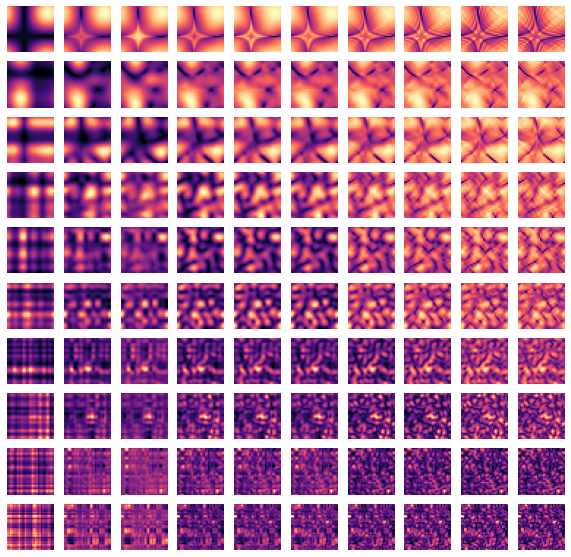

In [9]:
# Create the swapped datasets (swap eigenfeatures and singular values)
imax=10000 # 10000 images is a good benchmark. Easily run on a 32GB computer, but the same OoM as datasets like MNIST
dim = 32   # Test images are CiFAR10. CiFAR10 is 32x32
us=np.zeros((10,imax,32,32))
vs=np.zeros((10,imax,32,32))
ss=np.zeros((10,imax,32))
for i in range(10):
    for j in range(imax):
        us[i,j],ss[i,j],vs[i,j]=np.linalg.svd(datasets[i,j])
mixed_datasets=np.zeros((10,10,imax,32,32))
for i in range(10):
    for j in range(10):
        for k in range(imax):
            mixed_datasets[i,j,k]=np.matmul(np.matmul(us[i,k],np.eye(32)*ss[j,k]),vs[i,k])
# Plots the 51st image from each generated dataset
f,a=plt.subplots(10,10,figsize=(10,10))
for m in range(10):
    for n in range(10):
        a[m,n].imshow(mixed_datasets[m,n,50],cmap='magma')
        a[m,n].axis('off')
plt.show()

In [ ]:
## Vortex map maker
# Topological Charges
m1 = 1 ; m2 = 3

xmax = 10       # f-plane max
dim = 32        # Image Size
dx = 2*xmax/dim # f-plane pixel size

# Get cylindrical coord
x = np.linspace(-xmax,xmax-dx,dim)
X,Y=np.meshgrid(x,x)
R2=(X**2+Y**2)
T = np.arctan2(Y,X)

# Lens Parameters
flambda=80
Lens = np.exp(-1j*R2/(flambda/10))

# Vortex phase modulation
V1 = np.exp(1j*(m1)*T) 
V2 = np.exp(1j*(m2)*T)
LG1=Lens*V1 ; LG2=Lens*V2

# Plot phase to make sure it's the right shape
plt.imshow(np.angle(np.hstack((LG1,LG2))),cmap='twilight')
plt.axis('off')
plt.show()

# This function takes a numpy array of size [num_images, dim, dim]
# and applies a vortex phase, an fft, and an absolute value to each image
def vort_THIS(A,LGA,LGB):
    length=A.shape[0]
    out=np.zeros((length,A.shape[1],A.shape[2]*2))
    for i in range(length):
        A1=np.abs(myfft2(np.exp(1j*A[i]*np.pi/2)*LGA)) ; A2=np.abs(myfft2(np.exp(1j*A[i]*np.pi/2)*LGB))
        # Our single layer NN requires domain restriction within [-1,1]
        A1=(A1-np.amin(A1))/np.amax(A1-np.amin(A1))*2-1    ; A2=(A2-np.amin(A2))/np.amax(A2-np.amin(A2))*2-1
        out[i]=np.hstack((A1,A2))
    return out

In [ ]:
# Fits reconstruction models and saves them to relavent folders

historys = [[],[],[],[],[],[],[],[],[],[]]
models = [[],[],[],[],[],[],[],[],[],[]]
for i in range(10):
    models[i]=base_model()
    gt=np.zeros((imax,32,32))
    for j in range(imax):
        gt[j]=(datasets[i,j]-np.amin(datasets[i,j]))/np.amax(datasets[i,j]-np.amin(datasets[i,j]))
    X=vort_THIS(gt,LG1,LG2)
    historys[i]=(models[i].fit(X.reshape(X.shape[0],X.shape[1]*X.shape[2]), gt.reshape(gt.shape[0],gt.shape[1]*gt.shape[2]), validation_split=0.01,shuffle = True, verbose = 0, batch_size = 784*60,epochs=5000))
    

model_switch=[]
historys_switch=[]
for i in range(10):
    for j in range(10):
        if i==j:
            print(str(i) + ' by ' + str(j) + ' bypassed')
        else:
            model_switch.append(base_model())
            gt=np.zeros((imax,32,32))
            for k in range(imax):
                gt[k]=(mixed_datasets[i,j,k]-np.amin(mixed_datasets[i,j,k]))/np.amax(mixed_datasets[i,j,k]-np.amin(mixed_datasets[i,j,k]))
            X=vort_THIS(gt,LG1,LG2)
            historys_switch.append(model_switch[i].fit(X.reshape(X.shape[0],X.shape[1]*X.shape[2]), gt.reshape(gt.shape[0],gt.shape[1]*gt.shape[2]), validation_split=0.01,shuffle = True, verbose = 0, batch_size = 784*60,epochs=5000))
            print(str(i) + ' by ' + str(j) + ' done')
            model_switch[i].save('stochastic_swapped_models\\'+str(i)+'_eigenvectors_'+str(j)+'_SVs.h5')
for i in range(10):
    models[i].save('stochastic_base_models\\' +str(i) + '_speckles.h5' )